# Bag of visual words

Consider the problem of finding out similar images or photos. More formally, given an image you want to find out if there is similar image in a dataset of images.

To not compare pixel by pixel, one can use Visual Words to describe images. The concept comes from Text Retrieval and says that the image can be described by a set of visual words, i.e. visual features. A visual word is a "generalized" feature descriptor, most frequently is a mean value of a feature cluster.

So, we can describe an image with visual words and then aggregate this occurance of the words in the histograms. And then by comparing image histograms, we can figure out which images are visually similar, i.e., the images with the "smallest" histogram difference.

The problem occurs when the visual words occur in every image and thus from histogram perspective it is impossible to distinguish which images are similar and which are not.

For that, we can apply TF-IDF (Term Frequency - Inverse Document Frequence) reweighting that will downweight the "uninformative" (occuring everywhere) words and enhance the rare words. 

In this notebook, we are going to look at the example of how the TF-IDF reweighting works.

## TF-IDF weighting
Let's assume that we already have a bag of pre-trained visual words and we have 4 images that are represented with image histograms. In the example below image 0 and image 3 are similar. So we expect the matching algorithm report them as similar.
The weight for every word in every histogram can be  found
$$
t_i = \frac{n_{id}}{n_d}\log \frac{N}{n_i}
$$
where 
* $n_{id}$ -  occurance of word $i$ in a document $d$; 
* $n_d$ total number of words in a document $d$; 
* $n_i$ number of documents that contain the word $i$
* $N$ number of images

![](data/bag_of_words/histograms.png)

In the example above, image 0 has 5 blue words, 2 pink words, 1 green and no yellow or orange. The image has in total 8 features. With this we can already compute TF $\frac{n_{id}}{n_d}$ term which is $\frac{5}{8}$. The we can observe that yellow word occurs in all 4 images, whereas for example blue word occur only in one.
With this we can compute the weighting $t_i$ for all words in every histogram.

![](data/bag_of_words/ti_calculations.png)


After reweighting the histograms, we can notice that the words that occur a lot and everywhere (blue word) gets zero weight everywhere. Interestingly, if a word occurs only once per image but in every image (green) it also get zero weights. The pink words also get more prominent in the histograms. Also just by visual inspection, it is visible more that the histograms for image 0 and image 3 are more similar after reweighting then before.

![](data/bag_of_words/histogram_comparisons.png)




To be definitely confident that reweighting helps, let's look at the cost matrix, the matrix of all possible histograms comparisons. To the left the cost matrix is obtained by comparing histograms with Euclidean distance, to the right the cost matrix with inverse cosine distance for reweighted histograms.
Since image 0 and image 3 are similar, we expect the entries `cost_matrix[0][3]` and `cost_matrix[3][0]`
to be similar to `cost_matrix[0][0]` and `cost_matrix[3][3]`. And indeed for the reweighted case it is true.
Note, diagonal elements of the matrices result in 0 distance because we are comparing identical images.
![](data/bag_of_words/cost_matrices.png)

In [1]:
import numpy as np
N = 4
histograms = np.array([ [5,2,1,0,0],
                       [4,0,1,1,0],
                       [3,1,1,0,2],
                       [1,2,1,0,0]])
# Histrogram[0,:] - gets histogram for image 0

In [2]:
import matplotlib.pyplot as plt


def compute_cost_matrices(histograms):
    
    cost_matrix_eucl  = np.zeros((N,N))
    cost_matrix_cos  = np.zeros((N,N))

    for row, hist_row in enumerate(histograms):
        for col, hist_col in enumerate(histograms):
            eucl_dist = np.linalg.norm(hist_row-hist_col)
            cost_matrix_eucl[row, col] = eucl_dist
            cos_sim = np.dot(hist_row, hist_col) / (np.linalg.norm(hist_row)* np.linalg.norm(hist_col))
            cost_matrix_cos[row, col] = 1-cos_sim
    return cost_matrix_eucl, cost_matrix_cos

cm_eucl, cm_cos = compute_cost_matrices(histograms)

In [3]:
weighted_hist = np.array([ [0,0.07,0,0,0],
                           [0,0,0,0.23,0],
                           [0,0.04,0,0,2.4],
                           [0,0.14,0,0,0]])
# Histrogram[0,:] - gets histogram for image 0

Text(0.5, 1.0, 'Inv cosine')

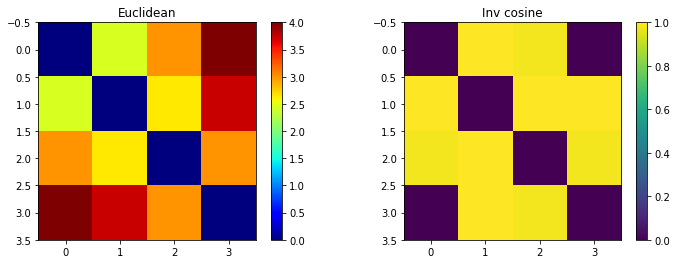

In [4]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_w, cm_cos_w = compute_cost_matrices(weighted_hist)


fig, ax = plt.subplots(1,2, figsize=(12,4));

axh0 = ax[0].imshow(cm_eucl, cmap='jet') 
plt.colorbar(axh0, ax = ax[0])
ax[0].set_title("Euclidean")

axh1 = ax[1].imshow(cm_cos_w, cmap='viridis') 
plt.colorbar(axh1, ax = ax[1])
ax[1].set_title("Inv cosine")


It seems that reweighted histograms finds similar images outside the diagonal elements whereas original histograms struggle to do so.